In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from Dataset import WeatherDataset

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
dataset_path = "./data/weather.csv"

In [5]:
split_date = pd.to_datetime('2023-01-01')
day_range = 15
days_in = 14

assert day_range > days_in, "day_range must be greater than days_in"

In [6]:
learning_rate = 1e-4
nepochs = 500
batch_size = 32

dataset_train = WeatherDataset(dataset_path, day_range, split_date)
dataset_test = WeatherDataset(dataset_path, day_range, split_date, train_test = "test")

In [7]:
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

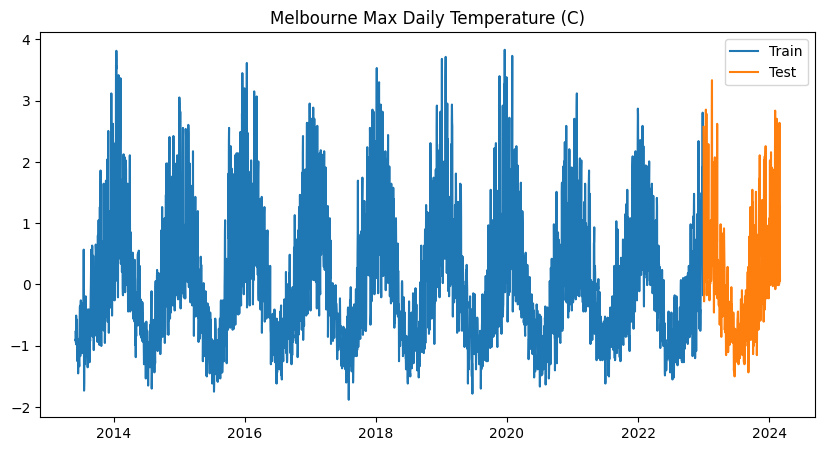

In [8]:
fig = plt.figure(figsize=(10, 5))
_ = plt.title("Melbourne Max Daily Temperature (C)")

_ = plt.plot(dataset_train.dataset.index, dataset_train.dataset.values[:, 1])
_ = plt.plot(dataset_test.dataset.index, dataset_test.dataset.values[:, 1])

_ = plt.legend(["Train", "Test"])

In [9]:
### Residual MLP Block
class ResBlockMLP(nn.Module) :
    def __init__(self, input_size, output_size) :
        super(ResBlockMLP, self).__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        self.norm2 = nn.LayerNorm(input_size//2)
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        self.fc3 = nn.Linear(input_size, output_size)
        
        self.act = nn.ELU()
        
    def forward(self, x) : 
        x = self.act(self.norm1(x))
        skip = self.fc3(x)
        
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        return x + skip
    
class ResMLP(nn.Module) : 
    def __init__(self, seq_len, output_size, num_blocks=1) : 
        super(ResMLP, self).__init__()
        
        seq_data_len = seq_len * 2
        
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),
            nn.LayerNorm(4 * seq_data_len),
            nn.Linear(4 * seq_data_len, 128)
        )
        
        blocks = [ResBlockMLP(128, 128) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        
        self.fc_out = nn.Linear(128, output_size)
        self.act = nn.ELU()
        
    def forward(self, input_seq):
        input_seq = input_seq.reshape(input_seq.shape[0], -1)
        input_vec = self.input_mlp(input_seq)

        x = self.act(self.res_blocks(input_vec))
        return self.fc_out(x)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weather_mlp = ResMLP(seq_len = days_in, output_size=2).to(device)

optimizer = optim.Adam(weather_mlp.parameters(), lr=learning_rate)

loss_fn = nn.MSELoss()

training_loss_logger = []

In [11]:
num_model_params = 0
for param in weather_mlp.parameters():
    num_model_params += param.flatten().shape[0]
    
print(f"Number of model parameters: {num_model_params}")

Number of model parameters: 51666


In [12]:
for epoch in trange(nepochs, desc="Epochs", leave=False):
    # Set the model to training mode
    weather_mlp.train()
    
    # Iterate over the training data loader
    for day, month, data_seq in tqdm(data_loader_train, desc="Training", leave=False):
        
        # Extract the initial sequence block to be used as input for the model
        seq_block = data_seq[:, :days_in].to(device)
        
        # Initialize the loss for the current batch
        loss = 0
        
        # Iterate over the remaining sequence to predict the next day values
        for i in range(day_range - days_in):
            # Get the target sequence block for the next day
            target_seq_block = data_seq[:, i + days_in].to(device)
            
            # Make predictions using the model
            data_pred = weather_mlp(seq_block)
            
            # Accumulate the loss for the current prediction
            loss += loss_fn(data_pred, target_seq_block)
            
            # Update the input sequence by removing the oldest date and adding the new prediction
            # Detach the new sequence to prevent backpropagation through the old sequence
            seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1).detach()

        # Average the accumulated loss over the number of steps
        loss /= i + 1
        
        # Zero the gradients before performing backpropagationz
        optimizer.zero_grad()
        
        # Perform backpropagation to compute gradients
        loss.backward()
        
        # Update the model parameters using the optimizer
        optimizer.step()
        
        # Log the training loss for later analysis
        training_loss_logger.append(loss.item())

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

Training:   0%|          | 0/109 [00:00<?, ?it/s]

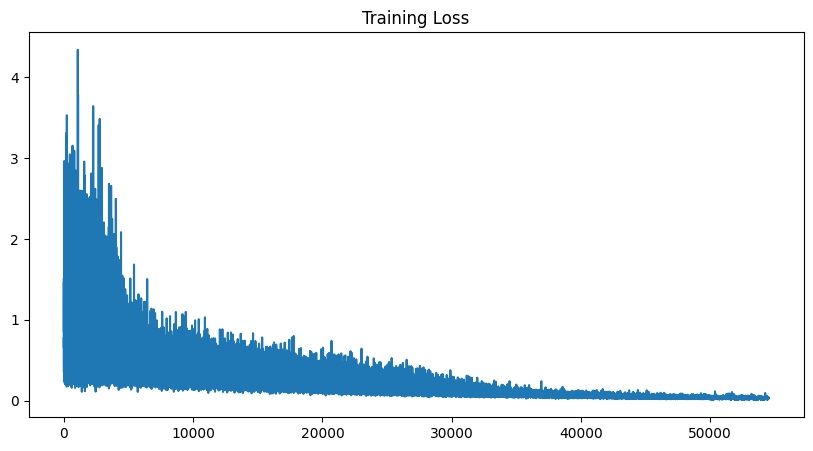

In [14]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger)
_ = plt.title("Training Loss")

In [15]:
# Convert the test dataset values to a PyTorch tensor
data_tensor = torch.FloatTensor(dataset_test.dataset.values)

# Initialize a list to log predictions
log_predictions = []

# Set the model to evaluation mode
weather_mlp.eval()

# Disable gradient calculation for the prediction process
with torch.no_grad():
    # Extract the initial sequence block to be used as input for the model
    # - unsqueeze(0) adds a batch dimension to the input
    seq_block = data_tensor[:days_in, :].unsqueeze(0).to(device)
    
    # Iterate over the sequence to predict the next day values
    for i in range(data_tensor.shape[0] - days_in):
        # Make predictions using the model
        data_pred = weather_mlp(seq_block)
        
        # Log the prediction
        log_predictions.append(data_pred.cpu())
        
        # Update the input sequence by removing the oldest date and adding the new prediction
        seq_block = torch.cat((seq_block[:, 1:, :], data_pred.unsqueeze(1)), 1)

# Concatenate the logged predictions into a single tensor
predictions_cat = torch.cat(log_predictions)

# Unnormalize the predictions using the dataset's standard deviation and mean
un_norm_predictions = (predictions_cat * dataset_test.std) + dataset_test.mean

# Unnormalize the original data using the dataset's standard deviation and mean
un_norm_data = (data_tensor * dataset_test.std) + dataset_test.mean

# Trim the initial sequence from the unnormalized data to match the length of predictions
un_norm_data = un_norm_data[days_in:]

In [16]:
test_mse = (un_norm_data - un_norm_predictions).pow(2).mean().item()
print("Test MSE value %.2f" % test_mse)

Test MSE value 37.45


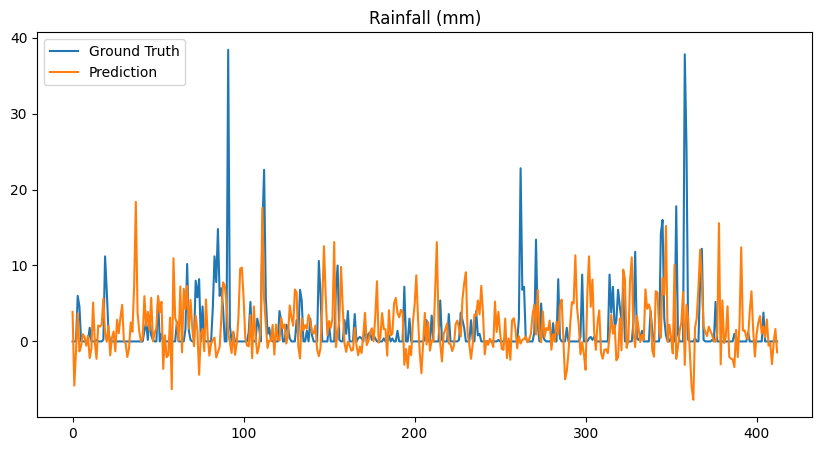

In [17]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(un_norm_data[:, 0])
_ = plt.plot(un_norm_predictions[:, 0])
_ = plt.title("Rainfall (mm)")

_ = plt.legend(["Ground Truth", "Prediction"])

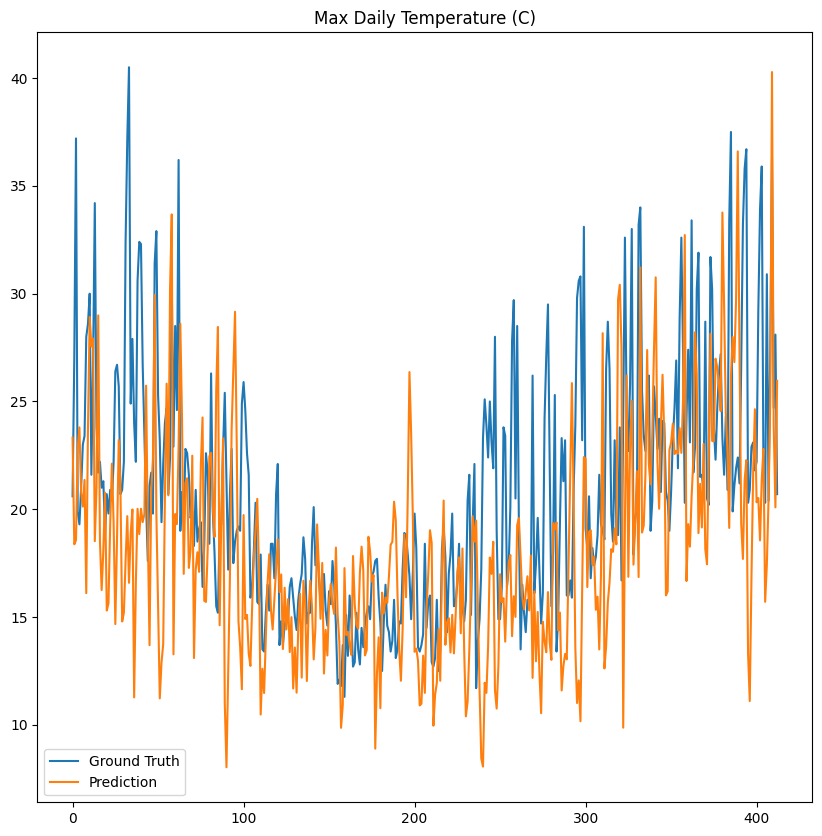

In [18]:
_ = plt.figure(figsize=(10, 10))
_ = plt.plot(un_norm_data[:, 1])
_ = plt.plot(un_norm_predictions[:, 1])
_ = plt.title("Max Daily Temperature (C)")

_ = plt.legend(["Ground Truth", "Prediction"])